<a href="https://colab.research.google.com/github/Harley7Damian/PhawAI_2025/blob/DeepLearning/DL_Proyecto_Damian_Mayerly_Clasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Clasificación con modelos preentrenados (Transfer Learning)**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Preprocessing (Resizing, Augmentation and Class Balancing)**

In [2]:
import os

# Check how many images in each folder
base_dir = '/content/drive/MyDrive/PhawAI/Deep Learning/dataset/The IQ-OTHNCCD lung cancer dataset'
class_names = ['Bengin cases', 'Malignant cases', 'Normal cases']

for class_name in class_names:
    class_folder = os.path.join(base_dir, class_name);
    files = [f for f in os.listdir(class_folder)]
    print(len(files))

120
561
416


In [5]:
import shutil
import random
from PIL import Image, ImageEnhance

# Reset output dir if already present
#output_dir = "/kaggle/working/balanced_dataset"
output_dir ="/content/drive/MyDrive/balanced_dataset"
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir)

# Define target count for each class after augmentation
target_count = 600
img_size = (512, 512)

# Define random transformations
def get_random_transform():
    options = [
        lambda img: img.transpose(Image.FLIP_LEFT_RIGHT),
        lambda img: img.transpose(Image.FLIP_TOP_BOTTOM),
        lambda img: img.rotate(random.uniform(-25, 25)),
        lambda img: ImageEnhance.Contrast(img).enhance(random.uniform(1.2, 1.8)),
        lambda img: ImageEnhance.Color(img).enhance(random.uniform(1.2, 2.0)),
        lambda img: ImageEnhance.Sharpness(img).enhance(random.uniform(1.5, 2.5))
    ]
    return random.choice(options)

def augment_and_save(class_name, target_count):
    class_src = os.path.join(base_dir, class_name)
    class_dst = os.path.join(output_dir, class_name)
    os.makedirs(class_dst)

    images = [f for f in os.listdir(class_src)]
    original_count = len(images)

    # Copy images to output_dir
    for img in images:
        shutil.copy(os.path.join(class_src, img), os.path.join(class_dst, img))

    # Check if original_count < target_count
    extra_needed = target_count - original_count
    if extra_needed <= 0:
        return

    print(f"Need to generate {extra_needed} new images for {class_name}")

    for i in range(extra_needed):
        img_name = random.choice(images)
        try:
            with Image.open(os.path.join(class_src, img_name)) as img:
                img = img.convert('RGB').resize(img_size)
                transformed_img = get_random_transform()(img)
                save_name = f"aug{i}_{img_name}"
                transformed_img.save(os.path.join(class_dst, save_name))
        except Exception as err:
            print(f"Error while augmenting: {err}")

for class_name in class_names:
    augment_and_save(class_name, target_count)

print("Augmentation complete for all classes!")

Need to generate 480 new images for Bengin cases
Need to generate 39 new images for Malignant cases
Need to generate 184 new images for Normal cases
Augmentation complete for all classes!


## **VGG16**

### **Training**

In [25]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG expects 224x224
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet means
                         [0.229, 0.224, 0.225])  # ImageNet std
])

#dataset = datasets.ImageFolder(root="/kaggle/working/balanced_dataset" , transform=data_transforms)
dataset = datasets.ImageFolder(root="/content/drive/MyDrive/balanced_dataset", transform=data_transforms)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

In [26]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.vgg16(pretrained=True)

# Freeze all layers except classifier
for param in model.features.parameters():
    param.requires_grad = False

# Replace the classifier (VGG16 has 4096 → 1000 classes by default)
model.classifier[6] = nn.Linear(4096, 3)  # 3 classes: Bengin, Malignant, Normal

model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10
vgg_train_losses = []
vgg_train_accuracies = []
vgg_val_losses = []
vgg_val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    vgg_train_losses.append(epoch_loss)
    vgg_train_accuracies.append(epoch_acc)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    vgg_val_losses.append(val_loss / len(val_loader))
    vgg_val_accuracies.append(val_correct / val_total)

    print(f"Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {vgg_val_losses[-1]:.4f}, Val Acc: {vgg_val_accuracies[-1]:.4f}")

    # ======= GUARDAR MODELO POR ÉPOCA =======
    torch.save(model.state_dict(), f"vgg_model_epoch_{epoch+1}.pth")

Epoch 1, Train Loss: 0.0445, Train Acc: 0.9840, Val Loss: 0.1010, Val Acc: 0.9639
Epoch 2, Train Loss: 0.0141, Train Acc: 0.9931, Val Loss: 0.0815, Val Acc: 0.9750
Epoch 3, Train Loss: 0.0163, Train Acc: 0.9944, Val Loss: 0.1042, Val Acc: 0.9778
Epoch 4, Train Loss: 0.0531, Train Acc: 0.9854, Val Loss: 0.1170, Val Acc: 0.9806
Epoch 5, Train Loss: 0.0678, Train Acc: 0.9799, Val Loss: 0.2091, Val Acc: 0.9472
Epoch 6, Train Loss: 0.0276, Train Acc: 0.9910, Val Loss: 0.1855, Val Acc: 0.9694
Epoch 7, Train Loss: 0.0189, Train Acc: 0.9938, Val Loss: 0.1171, Val Acc: 0.9667
Epoch 8, Train Loss: 0.0323, Train Acc: 0.9924, Val Loss: 0.2618, Val Acc: 0.9389
Epoch 9, Train Loss: 0.0924, Train Acc: 0.9764, Val Loss: 0.0882, Val Acc: 0.9806
Epoch 10, Train Loss: 0.0369, Train Acc: 0.9889, Val Loss: 0.2006, Val Acc: 0.9694


### **Evaluation Metrics**

VGG16 Evaluation Metrics:
Accuracy: 0.9694
Precision: 0.9713
Recall: 0.9694
F1 Score: 0.9696


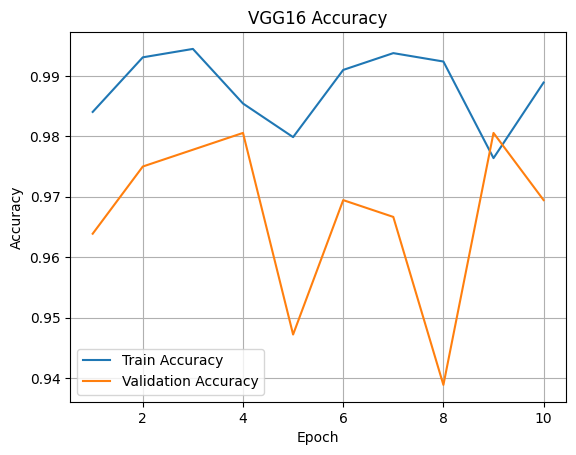

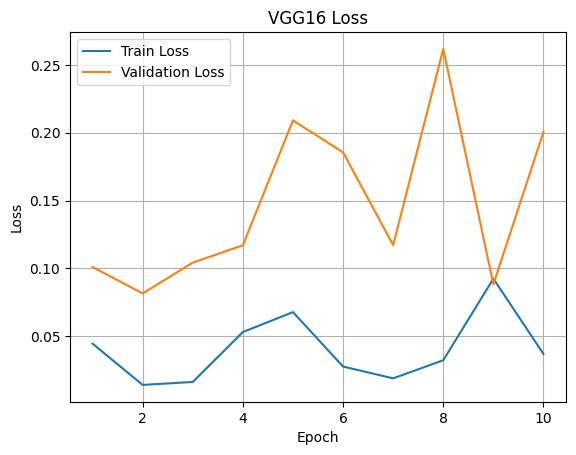

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
import numpy as np
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_labels = []
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

# Compute metrics
sklearn_accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Save to dictionary
vgg_metrics = {
    'Accuracy': round(sklearn_accuracy, 4),
    'Precision': round(precision, 4),
    'Recall': round(recall, 4),
    'F1 Score': round(f1, 4)
}

print("VGG16 Evaluation Metrics:")
for key, value in vgg_metrics.items():
    print(f"{key}: {value}")

# Accuracy plot
plt.plot(range(1, num_epochs+1), vgg_train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), vgg_val_accuracies, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("VGG16 Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(range(1, num_epochs+1), vgg_train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), vgg_val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VGG16 Loss")
plt.legend()
plt.grid(True)
plt.show()

In [32]:
plt.savefig("plt.png", dpi=300, bbox_inches="tight")
plt.show()

<Figure size 640x480 with 0 Axes>

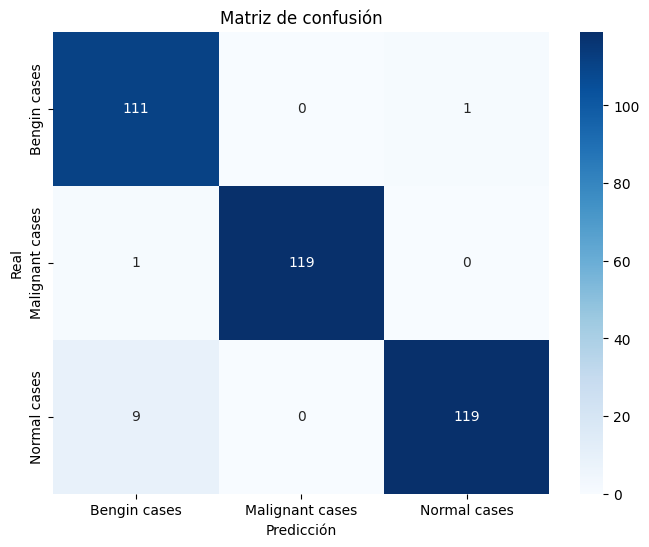

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión")
plt.show()

## **ResNet50**

### **Training**

In [10]:
import torchvision.models as models
import torch.nn as nn

# Load pretrained ResNet50
resnet50 = models.resnet50(pretrained=True)

num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 3)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 178MB/s]


In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.0001)

# Training loop
epochs = 10
rn_train_losses = []
rn_train_accuracies = []
rn_val_losses = []
rn_val_accuracies = []

for epoch in range(epochs):
    resnet50.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    rn_train_losses.append(epoch_loss)
    rn_train_accuracies.append(epoch_acc)

    # Validation loop
    resnet50.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet50(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    rn_val_losses.append(val_loss / len(val_loader))
    rn_val_accuracies.append(val_correct / val_total)

    print(f"Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {rn_val_losses[-1]:.4f}, Val Acc: {rn_val_accuracies[-1]:.4f}")


Epoch 1, Train Loss: 0.3047, Train Acc: 0.8840, Val Loss: 0.1305, Val Acc: 0.9611
Epoch 2, Train Loss: 0.0613, Train Acc: 0.9764, Val Loss: 0.0357, Val Acc: 0.9861
Epoch 3, Train Loss: 0.0404, Train Acc: 0.9875, Val Loss: 0.0533, Val Acc: 0.9833
Epoch 4, Train Loss: 0.0280, Train Acc: 0.9917, Val Loss: 0.0242, Val Acc: 0.9861
Epoch 5, Train Loss: 0.0251, Train Acc: 0.9903, Val Loss: 0.0284, Val Acc: 0.9972
Epoch 6, Train Loss: 0.0149, Train Acc: 0.9938, Val Loss: 0.0289, Val Acc: 0.9889
Epoch 7, Train Loss: 0.0085, Train Acc: 0.9972, Val Loss: 0.1085, Val Acc: 0.9611
Epoch 8, Train Loss: 0.0054, Train Acc: 0.9993, Val Loss: 0.0449, Val Acc: 0.9833
Epoch 9, Train Loss: 0.0466, Train Acc: 0.9875, Val Loss: 0.0946, Val Acc: 0.9750
Epoch 10, Train Loss: 0.0210, Train Acc: 0.9965, Val Loss: 0.0775, Val Acc: 0.9833


### **Evaluation Metrics**

ResNet50 Evaluation Metrics:
Accuracy: 0.98
Precision: 0.9838
Recall: 0.9833
F1 Score: 0.9833


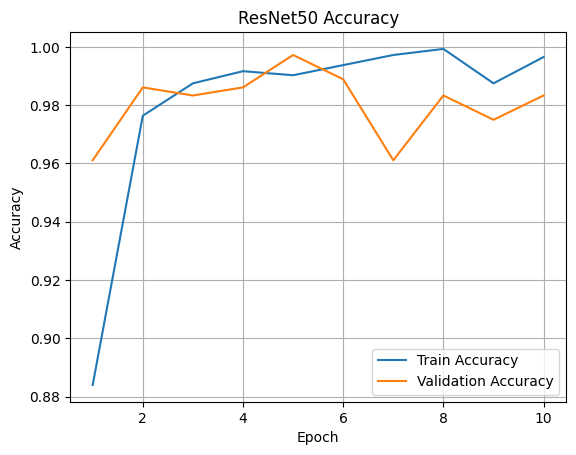

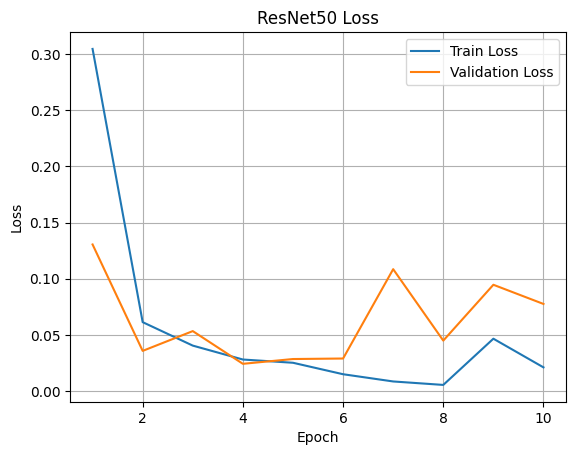

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

epochs = 10

resnet50.eval()
all_preds = []
all_labels = []
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

# Compute metrics
resnet_metrics = {
    'Accuracy': round(correct / total, 2),
    'Precision': round(precision_score(y_true, y_pred, average='weighted'), 4),
    'Recall': round(recall_score(y_true, y_pred, average='weighted'), 4),
    'F1 Score': round(f1_score(y_true, y_pred, average='weighted'), 4)
}

# Print metrics
print("ResNet50 Evaluation Metrics:")
for key, value in resnet_metrics.items():
    if key != 'Model':
        print(f"{key}: {value}")

# Accuracy plot
plt.plot(range(1, epochs+1), rn_train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), rn_val_accuracies, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ResNet50 Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(range(1, epochs+1), rn_train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), rn_val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ResNet50 Loss")
plt.legend()
plt.grid(True)
plt.show()

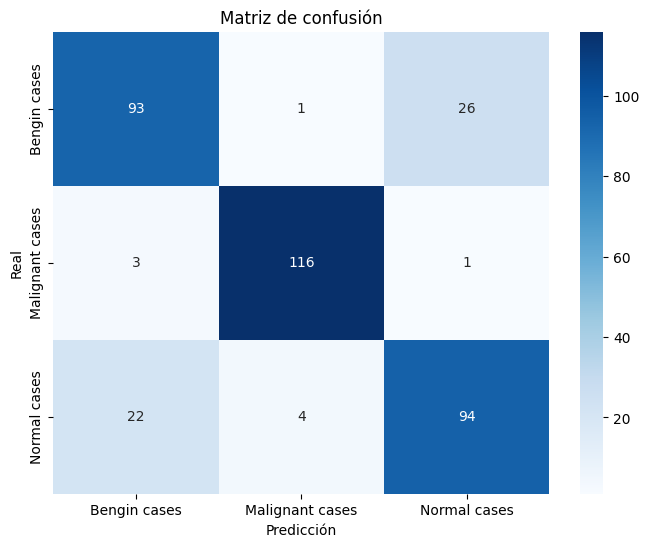

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión")
plt.show()

## **MobileNet V2**

### **Training**

In [14]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

#data_dir = "/kaggle/working/balanced_dataset"
data_dir = "/content/drive/MyDrive/balanced_dataset"
img_size = (224, 224)
batch_size = 32
epochs = 50

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_gen, validation_data=val_gen, epochs=epochs)

# Step 1: Predict on validation data
y_pred_probs = model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_gen.classes

Found 1440 images belonging to 3 classes.
Found 360 images belonging to 3 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 550ms/step - accuracy: 0.3492 - loss: 1.3739 - val_accuracy: 0.5250 - val_loss: 0.9481
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.4811 - loss: 1.0540 - val_accuracy: 0.6194 - val_loss: 0.8330
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 237ms/step - accuracy: 0.5604 - loss: 0.9159 - val_accuracy: 0.6194 - val_loss: 0.7624
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 240ms/step - accuracy: 0.6454 - loss: 0.7911 - val_accuracy: 0.6639 - val_loss: 0.7133
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 234ms/step - accuracy: 0.6472 - loss: 0.7638 - val_accuracy: 0.6611 - val_loss: 0.6830
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 240ms/step - accuracy: 0.6479 - loss: 0.7370 - val_accuracy: 0.6750 - val_loss: 0.6535
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 248ms/step - accuracy: 0.6975 - loss: 0.6505 - val_accuracy: 0.6889 - val_loss: 0.6333
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 228ms/step - accuracy: 0.7232 - loss: 0.6031 - val_accu

### **Evaluation Metrics**

MobileNetV2 Evaluation Metrics:
Accuracy: 84.17
Precision: 0.8412
Recall: 0.8417
F1 Score: 0.8414


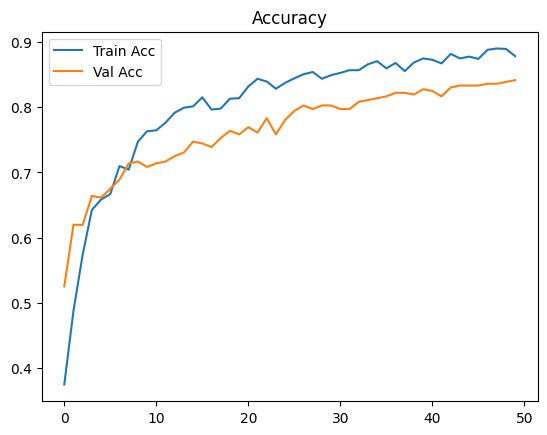

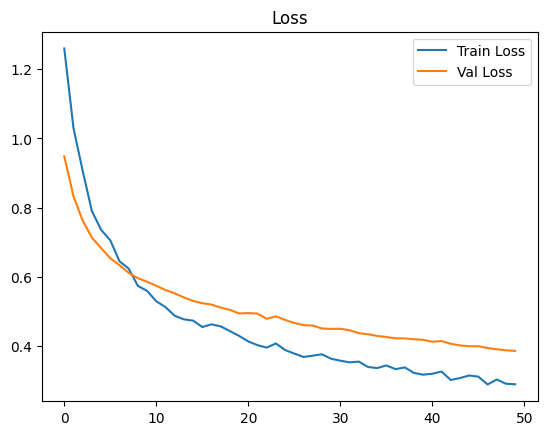

In [15]:
# Calculate metrics
mobilenet_metrics = {
    'Accuracy': round(accuracy_score(y_true, y_pred) * 100, 2),
    'Precision': round(precision_score(y_true, y_pred, average='weighted'), 4),
    'Recall': round(recall_score(y_true, y_pred, average='weighted'), 4),
    'F1 Score': round(f1_score(y_true, y_pred, average='weighted'), 4)
}

# Print the metrics
print("MobileNetV2 Evaluation Metrics:")
for key, value in mobilenet_metrics.items():
    print(f"{key}: {value}")

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()
plt.show()

# model.save("mobilenet_lung_model.h5")


## **COMPARACIÓN**

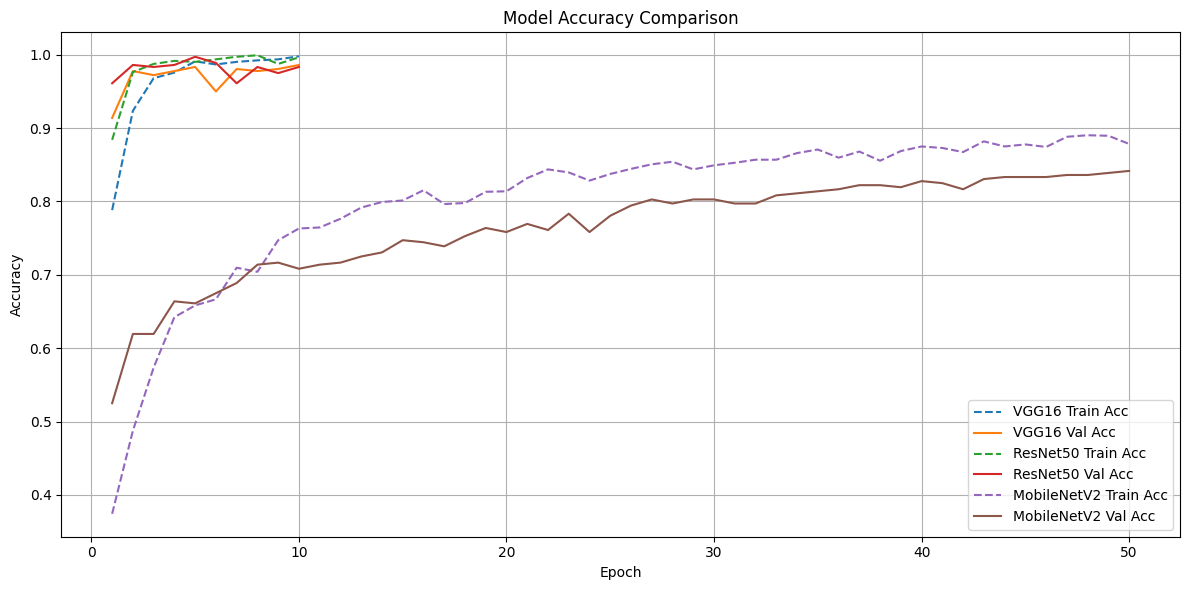

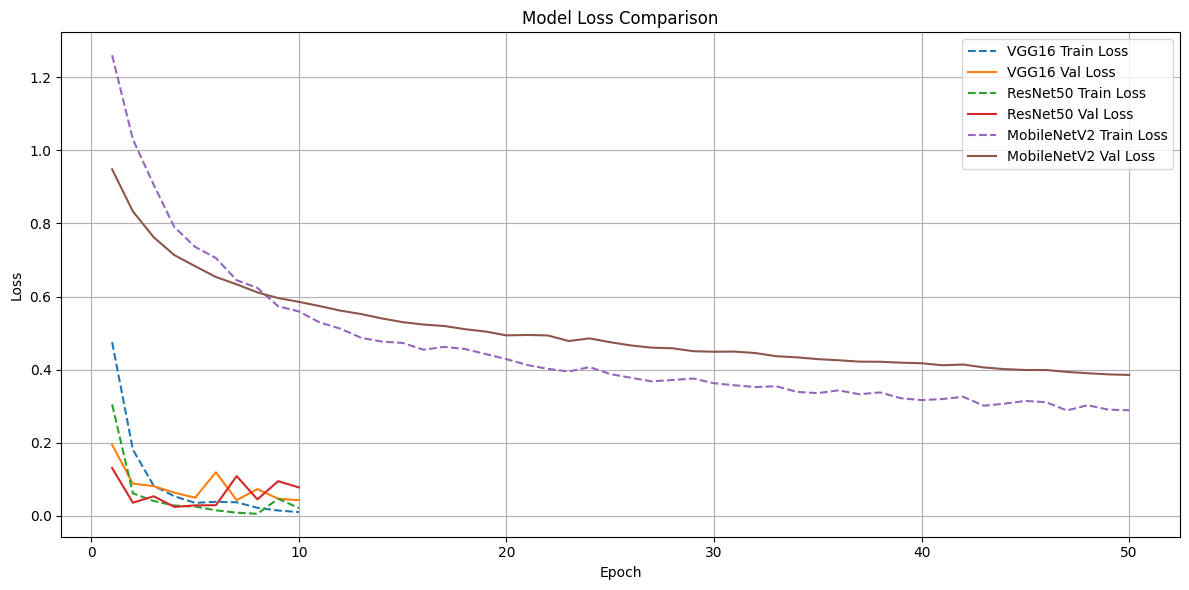

In [16]:
import matplotlib.pyplot as plt

# Epoch ranges
vgg_epochs = range(1, 11)
resnet_epochs = range(1, 11)
mobilenet_epochs = range(1, len(history.history['accuracy']) + 1)

# ACCURACY COMPARISON
plt.figure(figsize=(12, 6))
plt.plot(vgg_epochs, vgg_train_accuracies, '--', label='VGG16 Train Acc')
plt.plot(vgg_epochs, vgg_val_accuracies, label='VGG16 Val Acc')

plt.plot(resnet_epochs, rn_train_accuracies, '--', label='ResNet50 Train Acc')
plt.plot(resnet_epochs, rn_val_accuracies, label='ResNet50 Val Acc')

plt.plot(mobilenet_epochs, history.history['accuracy'], '--', label='MobileNetV2 Train Acc')
plt.plot(mobilenet_epochs, history.history['val_accuracy'], label='MobileNetV2 Val Acc')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# LOSS COMPARISON
plt.figure(figsize=(12, 6))
plt.plot(vgg_epochs, vgg_train_losses, '--', label='VGG16 Train Loss')
plt.plot(vgg_epochs, vgg_val_losses, label='VGG16 Val Loss')

plt.plot(resnet_epochs, rn_train_losses, '--', label='ResNet50 Train Loss')
plt.plot(resnet_epochs, rn_val_losses, label='ResNet50 Val Loss')

plt.plot(mobilenet_epochs, history.history['loss'], '--', label='MobileNetV2 Train Loss')
plt.plot(mobilenet_epochs, history.history['val_loss'], label='MobileNetV2 Val Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

             Accuracy  Precision  Recall  F1 Score
Model                                             
VGG16          0.9861     0.9867  0.9861    0.9861
ResNet50       0.9800     0.9838  0.9833    0.9833
MobileNetV2   84.1700     0.8412  0.8417    0.8414


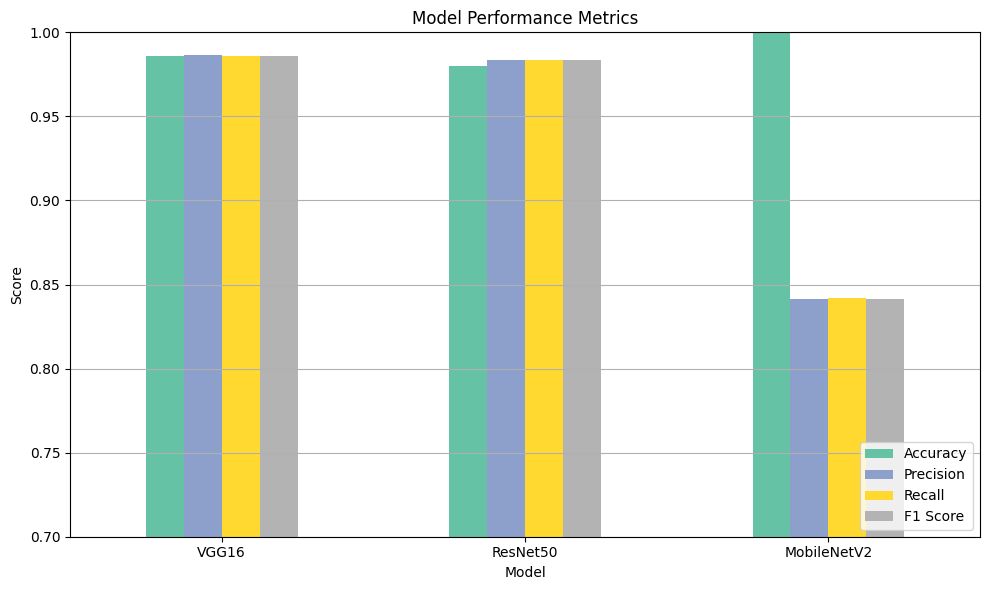

In [17]:
import pandas as pd

all_metrics = [
    {'Model': 'VGG16', **vgg_metrics},
    {'Model': 'ResNet50', **resnet_metrics},
    {'Model': 'MobileNetV2', **mobilenet_metrics}
]

# Create DataFrame
df = pd.DataFrame(all_metrics)

# Set model names as index
df.set_index('Model', inplace=True)

# Display
print(df)

# Plot all metrics
df.plot(kind='bar', figsize=(10, 6), colormap='Set2')
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0.7, 1.0)
plt.grid(True, axis='y')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

#**INFERENCIA DEL MODELO GANADOR: VGG16**

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


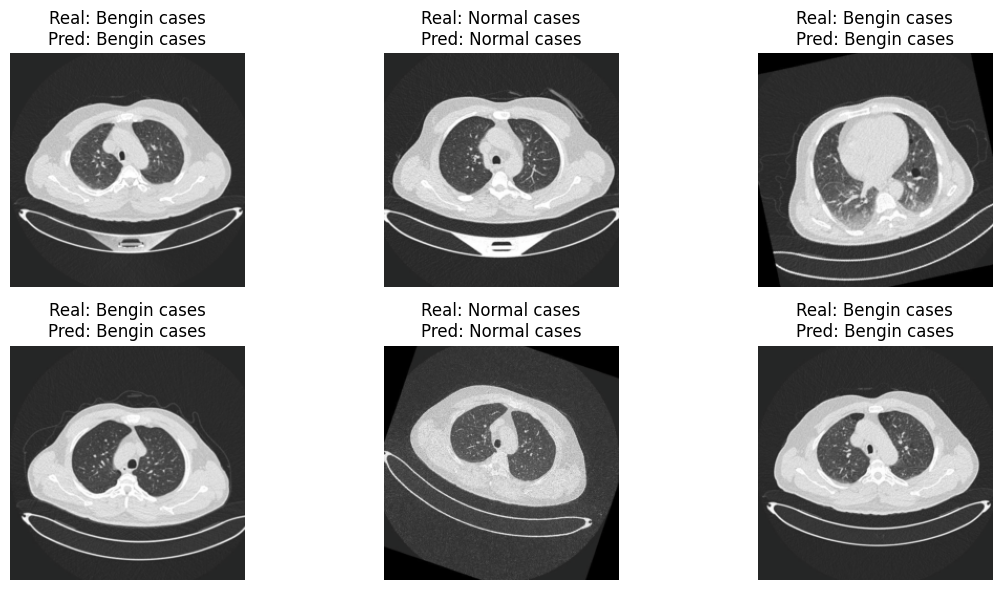

In [31]:
# 📌 4. Evidencias de inferencia con el modelo ganador (VGG16)

import torch
import matplotlib.pyplot as plt
import numpy as np
import random
from torchvision import datasets

# Ruta al dataset y al modelo guardado
data_dir = "/content/drive/MyDrive/balanced_dataset"
model_path = "/content/vgg_model_epoch_10.pth"
# Volvemos a cargar el dataset (para obtener imágenes de prueba)
inference_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)
class_names = inference_dataset.classes

# Cargar modelo VGG16 entrenado
from torchvision import models
model_vgg16 = models.vgg16(pretrained=False)
model_vgg16.classifier[6] = torch.nn.Linear(4096, len(class_names))  # salida según tus clases
model_vgg16.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
model_vgg16.eval()

# Función para mostrar imágenes con predicción
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis("off")

# Tomamos algunas imágenes aleatorias del dataset
fig = plt.figure(figsize=(12, 6))
for i in range(6):
    idx = random.randint(0, len(inference_dataset) - 1)
    img, label = inference_dataset[idx]
    with torch.no_grad():
        outputs = model_vgg16(img.unsqueeze(0))  # añadir batch dimension
        _, preds = torch.max(outputs, 1)
    ax = plt.subplot(2, 3, i+1)
    imshow(img, title=f"Real: {class_names[label]}\nPred: {class_names[preds[0]]}")
plt.tight_layout()
plt.show()


###**Nota de reproducibilidad y créditos**
Los experimentos presentados en este notebook se realizaron utilizando el dataset público IQ-OTH/NCCD - Lung Cancer Dataset disponible en Kaggle https://www.kaggle.com/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/data.

Asimismo, la implementación del código base fue adaptada y reproducida a partir del repositorio "VGG16_ResNet50_MobileNetV2"(https://www.kaggle.com/code/garvitgulati/vgg16-resnet50-mobilenetv2/notebook) desarrollado por Garvit Gulati (Kaggle, 2024). Las modificaciones realizadas en este trabajo corresponden al entrenamiento, análisis de resultados y generación de visualizaciones, con fines exclusivamente académicos.